# Projeto Final - Aprendizado de Máquinas

## Instalando e importando bibliotecas

In [ ]:
%pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import sklearn.naive_bayes as nb
from sklearn.neural_network import MLPClassifier as MLP
from lazypredict.Supervised import LazyClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Importando arquivos do dataset da competição
É necessário arrastar os arquivos _train.csv_ e _test.csv_ para o ambiente do Colab

In [ ]:
train = pd.read_csv('train.csv',index_col="PassengerId")
test = pd.read_csv('test.csv',index_col="PassengerId")

## Análise do Dataset (não processado)

### Informações básicas

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


### Matriz de Correlação

In [ ]:
train.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.00,0.07,0.13,0.03,0.12,0.10,-0.08
RoomService,0.07,1.00,-0.02,0.05,0.01,-0.02,-0.24
FoodCourt,0.13,-0.02,1.00,-0.01,0.22,0.23,0.05
ShoppingMall,0.03,0.05,-0.01,1.00,0.01,-0.01,0.01
Spa,0.12,0.01,0.22,0.01,1.00,0.15,-0.22
VRDeck,0.10,-0.02,0.23,-0.01,0.15,1.00,-0.21
Transported,-0.08,-0.24,0.05,0.01,-0.22,-0.21,1.00


### Quantidade de dados ausentes no conjunto de treinamento

In [ ]:
train.isna().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

### Quantidade de dados ausentes no conjunto de teste

In [ ]:
test.isna().sum()

HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

## Pipelines básicos de pré-processamento

### Versão original (abreviando todos os gastos em uma só variável - PIORES RESULTADOS)

In [ ]:
def pipeline_pre_processing(dfa):
    df = dfa.copy()
    df[['deck','num', 'side']] = df['Cabin'].str.split('/', expand=True)

    #one-hot encode homeplanet
    homeplanet = pd.get_dummies(df['HomePlanet'], prefix='HomePlanet')
    destination = pd.get_dummies(df.Destination,prefix='Destination') #encoder.fit_transform(df.Destination.to_numpy().reshape(-1,1))
    deck = pd.get_dummies(df.deck,prefix='deck')

    df.side = df.side.interpolate('linear')#.fillna(method = 'ffill')
    side = pd.get_dummies(df.side,prefix='side')

    TO_DROP = ["Name","Cabin",'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    column_order = homeplanet.columns.tolist()+['CryoSleep']+deck.columns.tolist()+['num']+side.columns.tolist() +destination.columns.tolist() +  ['Age', 'VIP','Spents']

    #df.side = df.side.map({"P":False,"S":True})
    #side to one-hot encode


    # Change types
    df.CryoSleep = df.CryoSleep.astype(bool)
    df.VIP = df.VIP.astype(bool)
    df.num = df.num.astype(np.float32)

    df.loc[:,"Spents"] = df[['RoomService',	'FoodCourt','ShoppingMall',	'Spa','VRDeck']].sum(axis=1)
    
    # FillNa
    df.Age = df.Age.fillna(df.Age.mean(), inplace=False)
    df.num = df.num.fillna(df.num.mean(), inplace=False)
    
    df = pd.concat([homeplanet,df[['CryoSleep']],deck,df[['num']],
                    side,destination,df[['Age', 'VIP','Spents']]],axis=1)[column_order]
    return df

### Versão corrigida

In [ ]:
def pipeline_pre_processing_alt(dfa):
    df = dfa.copy()
    df[['deck','num', 'side']] = df['Cabin'].str.split('/', expand=True)

    #one-hot encode
    homeplanet = pd.get_dummies(df['HomePlanet'], prefix='HomePlanet')
    destination = pd.get_dummies(df.Destination,prefix='Destination')
    deck = pd.get_dummies(df.deck,prefix='deck')

    df.side = df.side.interpolate('linear')
    side = pd.get_dummies(df.side,prefix='side')

    TO_DROP = ["Name","Cabin",'RoomService']
    column_order = homeplanet.columns.tolist()+['CryoSleep']+deck.columns.tolist()+['num']+side.columns.tolist() +destination.columns.tolist() +  ['Age', 'VIP', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    # Change types
    df.CryoSleep = df.CryoSleep.astype(bool)
    df.VIP = df.VIP.astype(bool)
    df.num = df.num.astype(np.float32)
    
    # FillNa
    df.Age = df.Age.fillna(df.Age.mean(), inplace=False)
    df.num = df.num.fillna(df.num.mean(), inplace=False)
    df.FoodCourt = df.FoodCourt.fillna(df.FoodCourt.mean(), inplace=False)
    df.ShoppingMall = df.ShoppingMall.fillna(df.ShoppingMall.mean(), inplace=False)
    df.Spa = df.Spa.fillna(df.Spa.mean(), inplace=False)
    df.VRDeck = df.VRDeck.fillna(df.VRDeck.mean(), inplace=False)
    
    df = pd.concat([homeplanet,df[['CryoSleep']],deck,df[['num']],
                    side,destination,df[['Age', 'VIP', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]],axis=1)[column_order]
    return df

## Funções adicionais de pré-processamento

### Normalização dos dados

In [ ]:
def normalize_df(xtrain, xtest):
    mms = MinMaxScaler()
    mms.fit(xtrain)

    xtrain_norm = mms.transform(xtrain)
    xtest_norm = mms.transform(xtest)

    df_xtrain = pd.DataFrame(data=xtrain_norm, index = xtrain.index, columns = xtrain.columns)
    df_xtest = pd.DataFrame(data=xtest_norm, index = xtest.index, columns = xtest.columns)

    return df_xtrain, df_xtest

### PCA realizando padronização dos dados

In [ ]:
def pca(xtrain, xtest, n_comp):
    ss = StandardScaler()
    ss.fit(xtrain)

    xtrain_norm = ss.transform(xtrain)
    xtest_norm = ss.transform(xtest)

    pca = PCA(n_components = n_comp)

    pca.fit(xtrain_norm)

    xtrain_pca = pca.transform(xtrain_norm)
    xtest_pca = pca.transform(xtest_norm)

    df_xtrain = pd.DataFrame(data=xtrain_pca, index = xtrain.index, columns = ['nf'+str(i+1) for i in range(n_comp)])
    df_xtest = pd.DataFrame(data=xtest_pca, index = xtest.index, columns = ['nf'+str(i+1) for i in range(n_comp)])

    return df_xtrain, df_xtest

### PCA sem padronização

In [ ]:
def pca_ws(xtrain, xtest, n_comp):
    xtrain_norm = xtrain
    xtest_norm = xtest

    pca = PCA(n_components = n_comp)

    pca.fit(xtrain_norm)

    xtrain_pca = pca.transform(xtrain_norm)
    xtest_pca = pca.transform(xtest_norm)

    df_xtrain = pd.DataFrame(data=xtrain_pca, index = xtrain.index, columns = ['nf'+str(i+1) for i in range(n_comp)])
    df_xtest = pd.DataFrame(data=xtest_pca, index = xtest.index, columns = ['nf'+str(i+1) for i in range(n_comp)])

    return df_xtrain, df_xtest

### Função para exclusão de atributos com pouca correlação com a saída
OBS.: Caso um determinado atributo tenha correlação com a saída de módulo menor que o limiar, ele é excluído

In [ ]:
def drop_columns(xtrain, xtest, ytrain, threshold):

    columnsToDrop = []

    for i in range(0, len(xtrain.columns)):
        if np.abs(pd.concat([xtrain[xtrain.columns[i]], ytrain], axis=1).corr().iloc[0,1]) <= np.abs(threshold):
            columnsToDrop.append(i)
    
    xtrain_drop = xtrain.drop(columns = xtrain.columns[columnsToDrop])
    xtest_drop = xtest.drop(columns = xtest.columns[columnsToDrop])

    return xtrain_drop, xtest_drop

### Função para realizar treinamento, predição e exportar os resultados obtidos no formato adequado para o Kaggle

In [ ]:
def fit_save(model,name,xtrain, ytrain,xtest):
    model.fit(xtrain,ytrain)
    result = model.predict(xtest).astype(bool)
    pd.DataFrame({'PassengerId':xtest.index.tolist(),'Transported':result.tolist()}).to_csv(name + '.csv', index=False)
    print('Saved')

### Função para realizar treinamento e predição, retornando os resultados em um array de booleanos

In [ ]:
def fit_Predict(model, xtrain, xtest, ytrain):
    model.fit(xtrain,ytrain)
    result = model.predict(xtest).astype(bool)
    return result

### Função para comparar resultados da predição com os do dataset



In [ ]:
def compare(result, ytest):
    percentage = 100 * len(np.where((result == ytest.to_numpy().reshape(1,-1)) == True)[0])/len(ytest)
    print("Acurácia de: " + str(np.round(percentage, 4)) + " %")
    print()
    print(classification_report(ytest, result))

## Divisão dos dados, pré-processamento e análises

### Aplicação do pipeline básico de pré-processamento nos dados de treinamento

In [ ]:
x_processed = pipeline_pre_processing_alt(train[train.columns[:-1]])
x_processed

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,...,side_S,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age,VIP,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0,1,0,False,0,1,0,0,0,0,...,0,0,0,1,39.00,False,0.00,0.00,0.00,0.00
0002_01,1,0,0,False,0,0,0,0,0,1,...,1,0,0,1,24.00,False,9.00,25.00,549.00,44.00
0003_01,0,1,0,False,1,0,0,0,0,0,...,1,0,0,1,58.00,True,3576.00,0.00,6715.00,49.00
0003_02,0,1,0,False,1,0,0,0,0,0,...,1,0,0,1,33.00,False,1283.00,371.00,3329.00,193.00
0004_01,1,0,0,False,0,0,0,0,0,1,...,1,0,0,1,16.00,False,70.00,151.00,565.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0,1,0,False,1,0,0,0,0,0,...,0,1,0,0,41.00,True,6819.00,0.00,1643.00,74.00
9278_01,1,0,0,True,0,0,0,0,0,0,...,1,0,1,0,18.00,False,0.00,0.00,0.00,0.00
9279_01,1,0,0,False,0,0,0,0,0,0,...,1,0,0,1,26.00,False,0.00,1872.00,1.00,0.00


### Divisão dos dados

In [ ]:
x_train_split, x_test_split, y_train_split , y_test_split = train_test_split(x_processed, train[train.columns[-1]], test_size=0.2, random_state=42)

### Normalização dos dados

In [ ]:
x_train_split_norm, x_test_split_norm = normalize_df(x_train_split, x_test_split)
x_train_split_norm

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,...,side_S,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age,VIP,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,,,,,,,,,,,,
2513_01,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.35,0.00,0.00,0.00,0.04,0.00
2774_02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,1.00,0.22,0.00,0.04,0.00,0.00,0.00
8862_04,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,...,1.00,1.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00
8736_02,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,1.00,0.25,0.00,0.00,0.01,0.05,0.00
0539_02,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.46,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6076_01,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.23,0.00,0.00,0.01,0.03,0.00
5537_01,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,1.00,0.00,0.00,1.00,0.63,1.00,0.00,0.00,0.04,0.02
5756_06,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.28,0.00,0.00,0.02,0.00,0.00


### Matriz de correlação dos dados pré-processados

In [ ]:
pd.concat([x_train_split_norm, y_train_split], axis=1).corr()

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,...,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age,VIP,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
HomePlanet_Earth,1.00,-0.61,-0.53,-0.10,-0.18,-0.33,-0.33,-0.26,-0.05,0.06,...,-0.14,0.22,-0.01,-0.21,-0.10,-0.21,-0.07,-0.16,-0.15,-0.17
HomePlanet_Europa,-0.61,1.00,-0.28,0.09,0.30,0.54,0.53,0.08,-0.07,-0.39,...,0.29,-0.16,-0.15,0.22,0.09,0.37,-0.01,0.28,0.28,0.17
HomePlanet_Mars,-0.53,-0.28,1.00,0.03,-0.09,-0.16,-0.15,0.24,0.14,0.34,...,-0.12,-0.10,0.17,0.02,0.04,-0.13,0.11,-0.09,-0.11,0.03
CryoSleep,-0.10,0.09,0.03,1.00,-0.02,0.12,0.03,-0.07,-0.12,-0.22,...,0.07,0.10,-0.11,-0.07,-0.05,-0.20,-0.20,-0.20,-0.18,0.45
deck_A,-0.18,0.30,-0.09,-0.02,1.00,-0.05,-0.05,-0.04,-0.06,-0.12,...,0.09,-0.05,-0.05,0.08,0.08,0.10,-0.02,0.06,0.08,0.00
deck_B,-0.33,0.54,-0.16,0.12,-0.05,1.00,-0.10,-0.08,-0.10,-0.22,...,0.17,-0.10,-0.09,0.11,0.03,0.16,-0.01,0.12,0.13,0.14
deck_C,-0.33,0.53,-0.15,0.03,-0.05,-0.10,1.00,-0.07,-0.10,-0.21,...,0.17,-0.08,-0.09,0.13,0.05,0.27,0.02,0.16,0.20,0.11
deck_D,-0.26,0.08,0.24,-0.07,-0.04,-0.08,-0.07,1.00,-0.08,-0.17,...,0.02,-0.04,0.01,0.08,0.05,0.02,0.05,0.04,-0.00,-0.03
deck_E,-0.05,-0.07,0.14,-0.12,-0.06,-0.10,-0.10,-0.08,1.00,-0.23,...,-0.07,-0.05,0.09,0.03,-0.01,-0.03,0.03,-0.01,-0.02,-0.09
deck_F,0.06,-0.39,0.34,-0.22,-0.12,-0.22,-0.21,-0.17,-0.23,1.00,...,-0.11,-0.01,0.09,-0.01,-0.03,-0.13,0.07,-0.09,-0.09,-0.10


### Exclusão dos atributos com baixa correlação

In [ ]:
x_train_split_norm_drop, x_test_split_norm_drop = drop_columns(x_train_split_norm, x_test_split_norm, y_train_split, 0.005)
x_train_split_norm_drop

,HomePlanet_Earth,HomePlanet_Europa,CryoSleep,deck_B,deck_C,side_P,side_S,Destination_55 Cancri e,Spa,VRDeck
PassengerId,,,,,,,,,,
2513_01,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00
2774_02,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
8862_04,0.00,1.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00
8736_02,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.05,0.00
0539_02,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
6076_01,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.03,0.00
5537_01,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.04,0.02
5756_06,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


### Aplicando PCA

In [ ]:
x_train_split_norm_drop_PCA, x_test_split_norm_drop_PCA = pca(x_train_split_norm_drop, x_test_split_norm_drop, 5)

x_train_split_norm_drop_PCA

,nf1,nf2,nf3,nf4,nf5
PassengerId,,,,,
2513_01,-0.79,-0.10,-0.00,0.86,0.71
2774_02,-1.35,0.77,1.28,0.03,1.12
8862_04,3.05,-1.67,-1.04,-1.67,-0.88
8736_02,-1.53,2.87,0.96,-1.04,0.47
0539_02,3.18,-1.19,1.74,-1.40,-1.18
...,...,...,...,...,...
6076_01,-1.65,-1.76,-1.31,0.88,-0.37
5537_01,-0.07,2.83,-1.83,-0.66,0.78
5756_06,-1.59,0.39,1.44,-1.53,1.22


### Aplicando PCA sem padronização dos dados

In [ ]:
x_train_split_norm_drop_PCAws, x_test_split_norm_drop_PCAws = pca_ws(x_train_split_norm_drop, x_test_split_norm_drop, 5)

## Predição usando Lazy Predict
Teste para comparar diversos classificadores simultâneamente

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

### Usando dados que passaram apenas pelo pré-processamento básico

In [ ]:
models, predictions = clf.fit(x_train_split, x_test_split, y_train_split, y_test_split)
models

100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.80,0.80,0.80,0.80,0.31
XGBClassifier,0.78,0.78,0.78,0.78,0.58
RandomForestClassifier,0.78,0.78,0.78,0.78,0.94
BaggingClassifier,0.76,0.76,0.76,0.76,0.30
AdaBoostClassifier,0.76,0.76,0.76,0.76,0.47
NuSVC,0.76,0.76,0.76,0.76,4.18
ExtraTreesClassifier,0.76,0.76,0.76,0.76,1.56
SVC,0.75,0.75,0.75,0.75,3.25
CalibratedClassifierCV,0.74,0.74,0.74,0.74,3.66


### Usando dados que passaram por normalização

In [ ]:
models, predictions = clf.fit(x_train_split_norm, x_test_split_norm, y_train_split, y_test_split)
models

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.80,0.80,0.80,0.80,0.31
XGBClassifier,0.79,0.79,0.79,0.79,0.60
RandomForestClassifier,0.79,0.79,0.79,0.79,1.42
NuSVC,0.78,0.78,0.78,0.78,3.62
ExtraTreesClassifier,0.78,0.78,0.78,0.78,0.77
SVC,0.78,0.78,0.78,0.78,3.05
BaggingClassifier,0.78,0.78,0.78,0.78,0.33
AdaBoostClassifier,0.77,0.77,0.77,0.77,0.41
KNeighborsClassifier,0.76,0.76,0.76,0.76,0.35


### Usando dados que passaram por exclusão de atributos

In [ ]:
models, predictions = clf.fit(x_train_split_norm_drop, x_test_split_norm_drop, y_train_split, y_test_split)
models

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.76,0.76,0.76,0.76,0.36
LGBMClassifier,0.75,0.75,0.75,0.75,0.17
NuSVC,0.75,0.75,0.75,0.74,3.09
SVC,0.74,0.75,0.75,0.74,2.45
LinearDiscriminantAnalysis,0.74,0.74,0.74,0.74,0.06
RidgeClassifierCV,0.74,0.74,0.74,0.74,0.05
RidgeClassifier,0.74,0.74,0.74,0.74,0.02
LinearSVC,0.74,0.74,0.74,0.74,0.45
LabelSpreading,0.74,0.74,0.74,0.74,4.03


### Usando dados que passaram pelo PCA

In [ ]:
models, predictions = clf.fit(x_train_split_norm_drop_PCA, x_test_split_norm_drop_PCA, y_train_split, y_test_split)
models

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.75,0.75,0.75,0.75,7.57
LGBMClassifier,0.75,0.75,0.75,0.75,0.19
ExtraTreesClassifier,0.75,0.75,0.75,0.75,0.72
RandomForestClassifier,0.75,0.75,0.75,0.74,1.75
BaggingClassifier,0.74,0.75,0.75,0.74,0.39
LabelPropagation,0.74,0.74,0.74,0.74,2.29
XGBClassifier,0.73,0.73,0.73,0.73,0.41
LabelSpreading,0.73,0.73,0.73,0.73,3.31
KNeighborsClassifier,0.73,0.73,0.73,0.73,0.07


### Usando dados que passaram pelo PCA sem normalização


In [ ]:
models, predictions = clf.fit(x_train_split_norm_drop_PCAws, x_test_split_norm_drop_PCAws, y_train_split, y_test_split)
models

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:17<00:00,  1.69it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.72,0.72,0.72,0.72,0.18
XGBClassifier,0.72,0.72,0.72,0.72,0.41
LabelSpreading,0.72,0.72,0.72,0.71,3.15
LabelPropagation,0.72,0.72,0.72,0.71,2.27
KNeighborsClassifier,0.71,0.71,0.71,0.71,0.06
AdaBoostClassifier,0.71,0.71,0.71,0.71,0.47
SGDClassifier,0.71,0.71,0.71,0.71,0.06
SVC,0.71,0.71,0.71,0.71,2.61
NuSVC,0.69,0.69,0.69,0.69,4.02


### Observação: baseado nas performances acima, a partir desse ponto são utilizados os dados que passaram pelo pipeline básico e pela normalização. A exclusão de atributos por correlação e o PCA não se mostraram técnicas vantajosas nesse contexto.

## Predições usando Categorical Naive Bayes, SVM e XGBoost

### Categorical NB

In [ ]:
clf_nb = nb.CategoricalNB()
print("Para Categorical Naive Bayes:")
result_nb = fit_Predict(clf_nb, x_train_split_norm, x_test_split_norm, y_train_split)
compare(result_nb, y_test_split)

Para Categorical Naive Bayes:
Acurácia de: 69.2352 %

              precision    recall  f1-score   support

       False       0.69      0.68      0.69       861
        True       0.69      0.71      0.70       878

    accuracy                           0.69      1739
   macro avg       0.69      0.69      0.69      1739
weighted avg       0.69      0.69      0.69      1739



### SVM

In [ ]:
clf_svm = svm.SVC()
print("Para SVM:")
result_svm = fit_Predict(clf_svm, x_train_split_norm, x_test_split_norm, y_train_split)
compare(result_svm, y_test_split)

Para SVM:
Acurácia de: 73.7205 %

              precision    recall  f1-score   support

       False       0.70      0.82      0.75       861
        True       0.79      0.66      0.72       878

    accuracy                           0.74      1739
   macro avg       0.74      0.74      0.74      1739
weighted avg       0.74      0.74      0.74      1739



### XGBoost

In [ ]:
clf_xgbc = xgb.XGBClassifier(max_depth= 4)
print("Para XGBoost:")
result_xgbc = fit_Predict(clf_xgbc, x_train_split_norm, x_test_split_norm, y_train_split)
compare(result_xgbc, y_test_split)

Para XGBoost:
Acurácia de: 79.701 %

              precision    recall  f1-score   support

       False       0.79      0.80      0.80       861
        True       0.80      0.80      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



## Resultados para o Kaggle

In [ ]:
x_train = pipeline_pre_processing_alt(train)
x_test_kaggle = pipeline_pre_processing_alt(test)
y_train = train[train.columns[-1]]

x_train_norm, x_test_kaggle_norm = normalize_df(x_train, x_test_kaggle)
x_train_norm_drop, x_test_kaggle_norm_drop = drop_columns(x_train_norm, x_test_kaggle_norm, y_train, 0)

fit_save(clf_nb, 'nb_norm', x_train_norm, y_train, x_test_kaggle_norm)
fit_save(clf_svm, 'svm_norm', x_train_norm, y_train, x_test_kaggle_norm)
fit_save(clf_xgbc, 'XGBC_norm', x_train_norm, y_train, x_test_kaggle_norm)

Saved
Saved
Saved


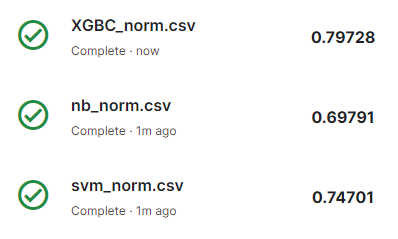